In [1]:
import pandas
import datetime
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import ticker
import seaborn as sns
import scipy
import feather
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
rel_perc_cutoff = 0.15

In [3]:
finBndDF = feather.read_dataframe('../data/trghBndDst.feather')
# There is 24 MLT and 0 MLT, remove the discrepancy
finBndDF["mlt"] = finBndDF["mlt"]%24
finBndDF = finBndDF.drop_duplicates()
finBndDF["dst_bin"] = finBndDF["dst_bin"].astype(str)

In [4]:
# Discard MLTs(for each dst_bin) where num observations are low
cntNMltDstPnts = finBndDF.groupby(["dst_bin", "normMLT"]).size().reset_index()
cntNMltDstPnts.columns = ["dst_bin", "normMLT", "cnt"]

cntMaxPnts = cntNMltDstPnts[ ["dst_bin", "cnt"] ].groupby("dst_bin").max().reset_index()
cntMaxPnts.columns = ["dst_bin", "max_cnt"]

cntNMltDstPnts = pandas.merge( cntNMltDstPnts, cntMaxPnts, on=["dst_bin"] )
cntNMltDstPnts["rel_perc"] = cntNMltDstPnts["cnt"]/cntNMltDstPnts["max_cnt"]
cntNMltDstPnts = cntNMltDstPnts[ cntNMltDstPnts["rel_perc"] > rel_perc_cutoff ].reset_index(drop=True)
cntNMltDstPnts = cntNMltDstPnts[ [ "dst_bin", "normMLT", "rel_perc" ] ]
cntNMltDstPnts.head()

,dst_bin,normMLT,rel_perc
0,"(-10, 10]",-3.0,0.168704
1,"(-10, 10]",-2.0,0.353223
2,"(-10, 10]",-1.0,0.601528
3,"(-10, 10]",0.0,0.818738
4,"(-10, 10]",1.0,0.960532


In [5]:
# discard trghMean locations where obse are low
finBndDF = pandas.merge( finBndDF, cntNMltDstPnts, on=["dst_bin", "normMLT"], how="inner" )

In [6]:
# Get season data
def get_season(row):
        currMonth = row["date"].month
#         return currMonth
        if ( (currMonth >= 11) or (currMonth <= 2) ):
            return "winter"#-1
        elif ( (currMonth >= 5) and (currMonth <= 8) ):
            return "summer"#1
        else:
            return "equinox"
        
finBndDF["season"] = finBndDF.apply( get_season, axis=1 )
finBndDF.head()

,mlatEqu,tecEqu,mlon,mlatPol,tecPol,date,mlatMin,tecMin,mlt,mlonAdjst,...,delTecPol,delMlat,timeStr,dateStr,hour,dst_date,dst_index,dst_bin,rel_perc,season
0,46.0,5.7,314.0,64.0,4.2,2011-04-18 07:15:00,55.0,3.2,23.0,-46.0,...,1.0,18.0,715,20110418,07,2011-04-18 07:00:00,9.0,"(-10, 10]",0.601528,equinox
1,53.0,4.9,338.0,64.0,3.5,2011-10-23 04:40:00,59.0,2.3,23.0,-22.0,...,1.2,11.0,440,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
2,51.0,4.9,340.0,64.0,3.4,2011-10-23 04:40:00,58.0,2.6,23.0,-20.0,...,0.8,13.0,440,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
3,50.0,4.9,342.0,64.0,4.3,2011-10-23 04:40:00,57.0,3.3,23.0,-18.0,...,1.0,14.0,440,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox
4,47.0,6.7,348.0,66.0,6.8,2011-10-23 04:40:00,56.0,4.9,23.0,-12.0,...,1.9,19.0,440,20111023,04,2011-10-23 04:00:00,3.0,"(-10, 10]",0.601528,equinox


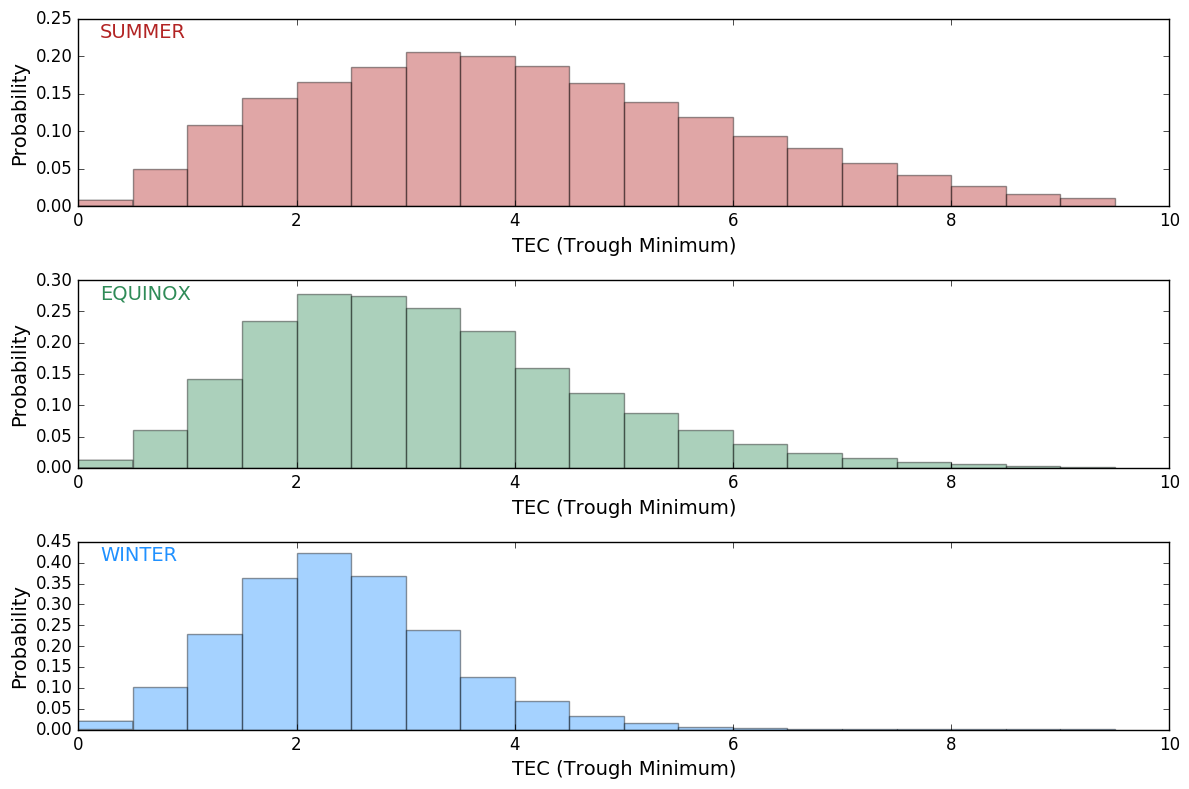

In [7]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "dodgerblue"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["tecMin"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("TEC (Trough Minimum)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-TEC-Min.eps",bbox_inches='tight')

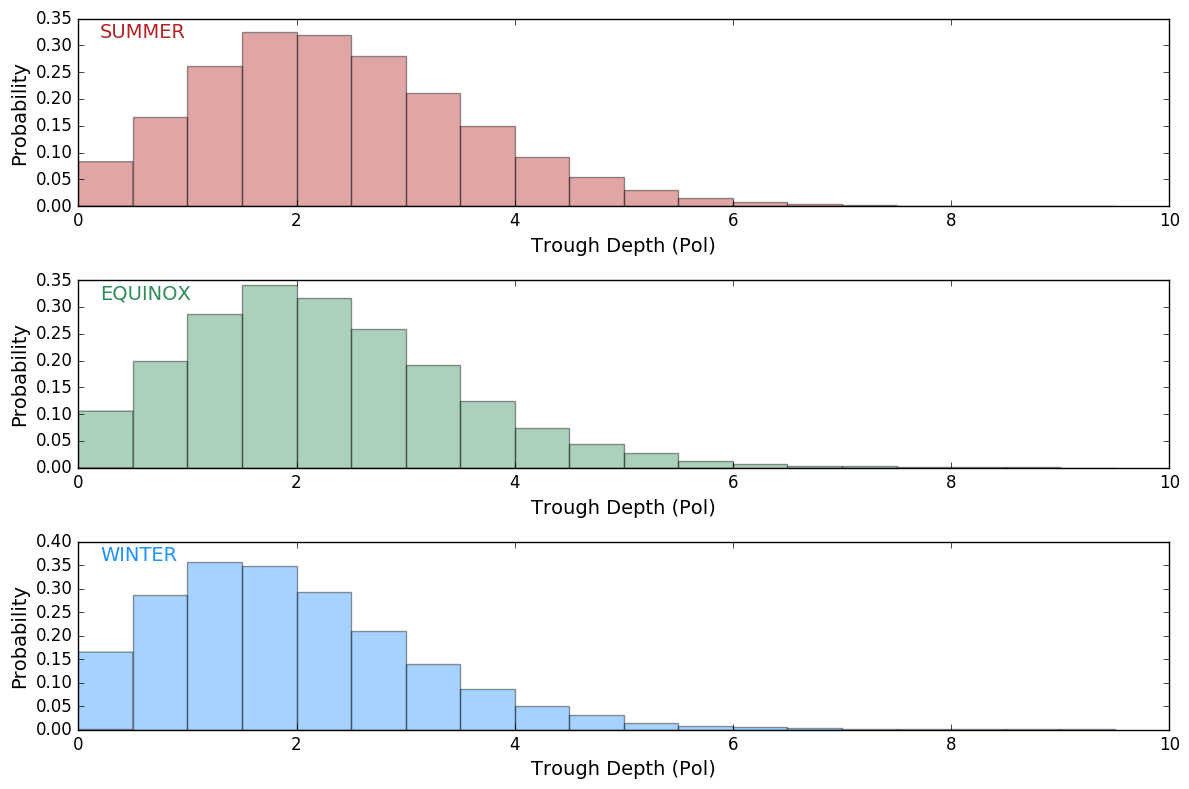

In [8]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "dodgerblue"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["delTecPol"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("Trough Depth (Pol)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Trgh-Dep-Pol.eps",bbox_inches='tight')

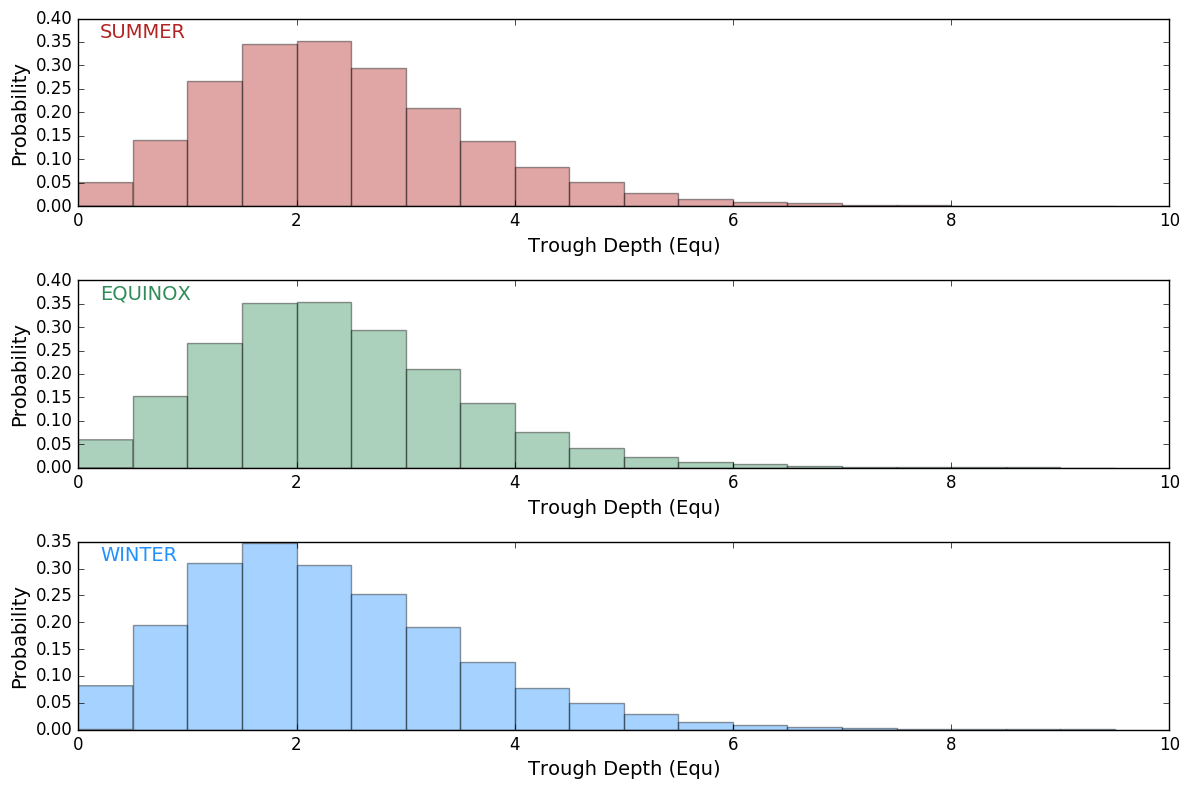

In [9]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "dodgerblue"
colDict["equinox"] = "seagreen"

bins = numpy.arange(0,10,0.5)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["delTecEqu"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("Trough Depth (Equ)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Trgh-Dep-Equ.eps",bbox_inches='tight')

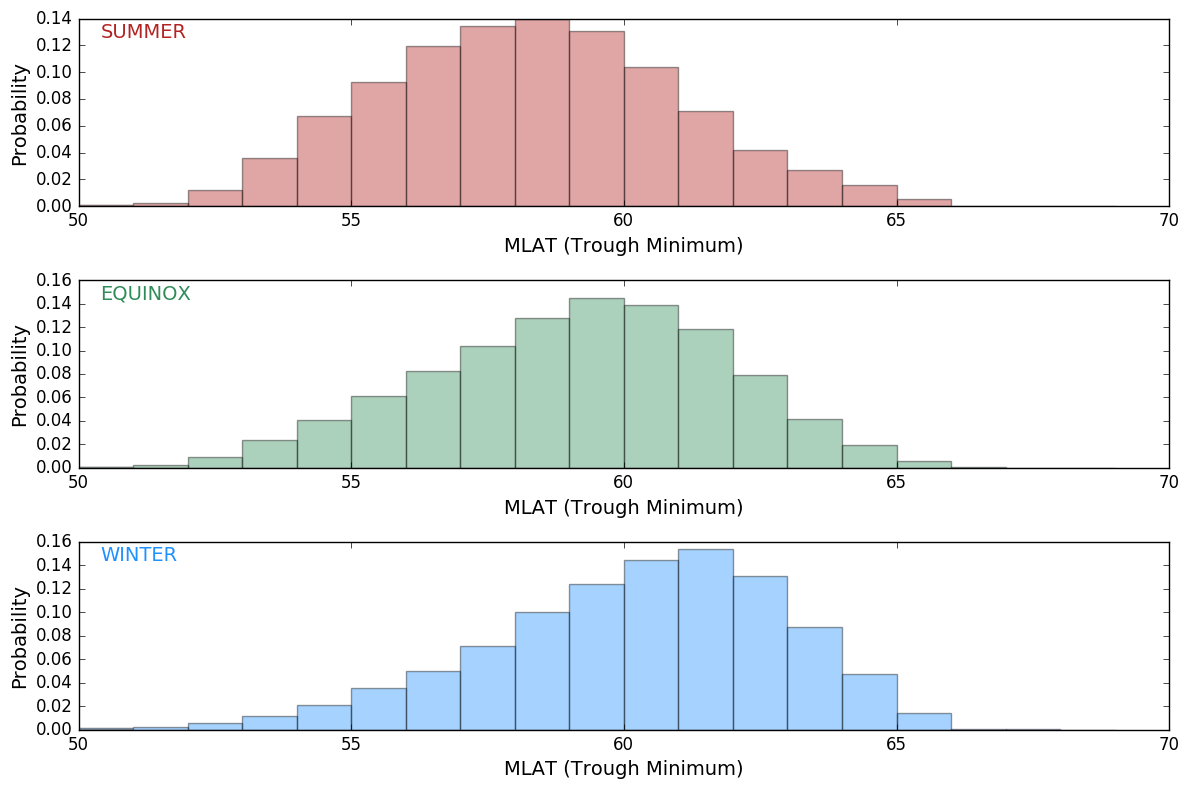

In [10]:
seasonList = [ "summer", "equinox", "winter" ]
colDict = {}
colDict["summer"] = "firebrick"
colDict["winter"] = "dodgerblue"
colDict["equinox"] = "seagreen"

bins = numpy.arange(50,70,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,1,1) )
axArr.append( f.add_subplot(3,1,2) )
axArr.append( f.add_subplot(3,1,3) )

for ssnInd, currSsn in enumerate(seasonList):
    selDF = finBndDF[ finBndDF["season"] == currSsn ]
    sns.distplot( selDF["mlatMin"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("MLAT (Trough Minimum)", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/Season-Mlat-TEC.eps",bbox_inches='tight')